<a id=top></a>

# Megafon

## Тестовое задание для аналитика больших данных

<a id=info></a>
### Info

#### Задача:
В связи с высоким уровнем проникновения услуг сотовой связи многие (не все) люди покупают для себя более, чем одну сим-карту, либо пользуются служебными сим-картами. Перед ОАО «МегаФон» стоит задача определить абонентов (msisdn), которые являются одной и той же Персоной (человеком). 
Для решения данной задачи предлагается использовать данные о перемещениях абонентов, собранные с базовых станций. Перемещения абонентов мобильной связи регистрируются на базовых станциях. Регистрация абонента на базовой станции означает нахождение в зоне действия данной базовой станции. Зоны действия различных базовых станций пересекаются. В одну и ту же точку на местности обычно ставят несколько базовых станций, которые либо «смотрят»  в разные стороны, либо поддерживают различные стандарты (2G/3G).
Требуется:  
а) 
- сформировать алгоритм определения Персоны на основании входных данных и представить его: 
- на языке Python (присылать код в формате *.ipynb. Комментарии по тексту кода желательны)
- Презентацию в формате *.ppt или *.pdf, в которой кратко изложить суть алгоритма
б) сформировать сущность Персона по предоставленному набору данных. Результат должен быть представлен в файле формата *.txt с двумя полями: 
1. Идентификатор Персоны (сгенерировать самостоятельно, например 1,2..N);
2. Номера телефонов из входных данных, которые данной Персоне с большой долей вероятности принадлежат

#### Входные данные: 

А. Информация о перемещении случайного набора абонентов (файл 02_Data.csv) за период 23-25 мая 2013 года, в котором точно присутствуют номера телефонов, принадлежащие одному и тому же человеку. Описание полей данных:

1. Lac – идентификатор группы базовых станций
2. cid – идентификатор базовой станции (уникален в рамках Lac)
3. msisdn – номер телефона абонента (в нашем случае зашифрованный) 
4. imei - http://ru.wikipedia.org/wiki/IMEI  
Первые 8 цифр imei называются TAC и определяют устройство, которым пользуется абонент. Сокращенный справочник TAC (файл 03_устройства) состоит из полей:
- tac – непосредственно сам TAC
- vendor – производитель телефона
- platform – операционная система на телефоне
- type – тип устройства (Phone – телефон, SmartPhone – смартфон, Laptop – планшет, ноутбук, Modem – модем, etc.)

5. event_type – каждая регистрации на базовой станции имеет свой тип. Справочник типов регистраций с расшифровкой в файле 04_event_type. Справочник получен от технической службы, полностью понять всё, что в нем написано не требуется.
6. tstamp – timestamp = количество 1/1000 секунды, прошедших с 01.01.1970 до времени регистрации на БС.
7. long – гео долгота размещения базовой станции
8. lat – гео широта размещения базовой станции
9. max_dist – максимальная дистанция приема в метрах
10. cell_type - типа размещения (может быть METRO - станция под землей, INDOOR - станция размещена внутри какого либо торгового центра или чего-то подобного, OUTDOOR - уличное размещение). 
11. start_angle - начало угла покрытия станции (0-360 по часовой стрелке, начиная с направления на север)
12. end_angle - конец угла покрытия станции (0-360 по часовой стрелке, начиная с направления на север)

В. Файл 01_Факты – обучающая выборка: набор пар номеров телефонов (msisdn), каждая из которых с большой долей вероятности принадлежит одной Персоне. Данные по передвижениям данных msisdn присутствуют в файле 02_Data.csv

<a id=load></a>
### Load Data and Modules

#### Load Modules

In [1]:
import pandas as pd
import numpy as np

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [4]:
from sklearn.decomposition import PCA

In [5]:
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

In [6]:
RANDOM_STATE = 42

#### Load data

In [7]:
facts = pd.read_excel('datasets/01_Факты.xlsx', header=None, names=['msisdn_1', 'msisdn_2'], dtype='str')
facts.head()

,msisdn_1,msisdn_2
0,158530067653,158528861653
1,158510912201,158528852857
2,158530063945,158528861599
3,158524011325,158524011355
4,158528852153,158528861475


In [8]:
data = pd.read_csv('datasets/02_Data.csv', sep=';', dtype={'imei': str, 'msisdn': str})
data.head()

,lac,cid,msisdn,imei,event_type,tstamp,long,lat,max_dist,cell_type,start_angle,end_angle
0,5029,40798,158529599791,353111050313790,0,1369252800974,37.9305,55.7815,2101,OUTDOOR,220.0,280.0
1,7782,56870,158520145943,012929002676510,5,1369252801396,37.4239,55.7426,2,OUTDOOR,45.0,105.0
2,7794,32226,158521798391,351994049226010,5,1369252802013,37.7034,55.5803,1125,OUTDOOR,0.0,60.0
3,7758,33528,158537830573,358627016731770,0,1369252802331,37.7895,55.7042,1158,OUTDOOR,210.0,270.0
4,5060,17568,158510204039,352458051767250,8,1369252803586,37.1900,55.8308,500,OUTDOOR,180.0,240.0


In [9]:
data.tstamp = pd.to_datetime(data.tstamp, unit='ms')

In [10]:
devices = pd.read_csv('datasets/03_устройства.csv', quoting=3) \
            .rename(lambda x: x.replace('"', ''), axis='columns') \
            .applymap(lambda x: x.replace('"', ''))
devices.head()

,tac,vendor,platform,type
0,00100429,PROTO,Proprietary,Phone
1,00100430,PROTO,Proprietary,Phone
2,00100431,PROTO,Proprietary,Phone
3,00100432,PROTO,Proprietary,Phone
4,00100433,PROTO,Proprietary,Phone


In [11]:
event_type = pd.read_excel('datasets/04_event_type.xlsx', index_col='Номер')
event_type

,Обозначение,Описание
Номер,,
0,loc_up_c,"Location Update. Каждый LU, совершаемый абонен..."
1,imsi_att_с,IMSI Attach. Включение телефона в той же облас...
2,par_c,Изменение местоположения абонента во время раз...
3,delete_c,Абонент удалён из VLR.
4,departing_с,"Пометка абонента как «неактивный» в случае, ес..."
5,detach_с,Абонент выключил свой телефон.
6,i_det_с,"Определение абонента, как «недоступный». (Не б..."
7,gprs_act_с,"Активность генерируется в том случае, если VLR..."
8,page_с,Изменение cid после входящего звонка или SMS. ...


<a id=explore></a>
### Исследование данных

Количество уникальных номеров (msisdn):

In [12]:
data.msisdn.nunique()

2361

#### Количество дубликатов в 01_Факты:

In [13]:
print(f'''Количество дубликатов в номерах:
msisdn_1: {facts.msisdn_1.duplicated().sum()}
msisdn_2: {facts.msisdn_2.duplicated().sum()}
''')

Количество дубликатов в номерах:
msisdn_1: 1
msisdn_2: 0



#### Набор данных абонентов за период с 22.05.2013 - 30.05.2013 (7 дней).

In [14]:
data.tstamp.min()

Timestamp('2013-05-22 20:00:00.974000')

In [15]:
data.tstamp.max()

Timestamp('2013-05-30 16:29:37.643000')

In [16]:
data.tstamp.max() - data.tstamp.min()

Timedelta('7 days 20:29:36.669000')

#### Проверка пересечений уникального номера imei у разных номеров:

Количество уникальных номеров imei:

In [17]:
data.imei.nunique()

2540

IMEI — это номер, обычно уникальный, для идентификации. Если один imei встречается паре с разными номерами (msisdn), то с большой долей вероятности эти номера принадлежат одной персоне.

In [18]:
imei = data.groupby('imei').agg({'msisdn': set})

In [19]:
msisdn_from_imei = imei[imei.msisdn.apply(len) > 1].msisdn.values

In [20]:
msisdn_from_imei = pd.DataFrame(list(msisdn_from_imei), columns=['msisdn_1', 'msisdn_2'])

In [21]:
msisdn_from_imei = msisdn_from_imei.astype('object')

In [22]:
msisdn_from_imei

,msisdn_1,msisdn_2
0,158502344213,158538940885
1,158505980497,158599067639
2,158522775359,158504290977
3,158506838305,158598318911
4,158508828513,158515886411
5,158517830421,158523332959
6,158537196953,158514324239
7,158522775359,158504290977
8,158517830421,158523332959
9,158527183389,158503655953


Анализ показал совпадение номеров imei у 11 пар номеров, что составляет менее 1% от общего количства уникальных номеров.

[Go to the top of the page](#top)

<a id=derived></a>
### Подготовка данных

Подготовка вектора пар номеров, которые с большой долей вероятности принадлежат одной персоне на базе набора данных 01_Факты

In [23]:
df_facts = facts.reset_index().rename(columns={'index': 'cluister', 'msisdn_1': 'msisdn', 'msisdn_2': 'msisdn_pair'})

In [24]:
df_cluister = pd.concat([df_facts, df_facts.rename(columns={'msisdn': 'msisdn_pair', 'msisdn_pair': 'msisdn'})]).reset_index(drop=True)

In [25]:
df_cluister

,cluister,msisdn,msisdn_pair
0,0,158530067653,158528861653
1,1,158510912201,158528852857
2,2,158530063945,158528861599
3,3,158524011325,158524011355
4,4,158528852153,158528861475
...,...,...,...
239,117,158537959439,158535693543
240,118,158522944879,158521773577
241,119,158507587401,158503697375
242,120,158525734415,158598992329


In [26]:
df = data.merge(df_cluister, how='left')

По tac добавляем информацию об устройстве

In [27]:
df['tac'] = df.imei.str.slice(stop=8)

In [28]:
df = df.merge(devices, how='left')

In [29]:
df = df.set_index((['msisdn', 'tstamp']))

In [30]:
df.head()

,,lac,cid,imei,event_type,long,lat,max_dist,cell_type,start_angle,end_angle,cluister,msisdn_pair,tac,vendor,platform,type
msisdn,tstamp,,,,,,,,,,,,,,,,
158529599791,2013-05-22 20:00:00.974,5029,40798,353111050313790,0,37.9305,55.7815,2101,OUTDOOR,220.0,280.0,NaN,NaN,35311105,LG,Android,SmartPhone
158520145943,2013-05-22 20:00:01.396,7782,56870,012929002676510,5,37.4239,55.7426,2,OUTDOOR,45.0,105.0,NaN,NaN,01292900,Apple,iOS,Laptop
158521798391,2013-05-22 20:00:02.013,7794,32226,351994049226010,5,37.7034,55.5803,1125,OUTDOOR,0.0,60.0,NaN,NaN,35199404,Nokia,ISA,Phone
158537830573,2013-05-22 20:00:02.331,7758,33528,358627016731770,0,37.7895,55.7042,1158,OUTDOOR,210.0,270.0,NaN,NaN,35862701,Nokia,ISA,Phone
158510204039,2013-05-22 20:00:03.586,5060,17568,352458051767250,8,37.1900,55.8308,500,OUTDOOR,180.0,240.0,NaN,NaN,35245805,Samsung,Proprietary,Phone


Для каждого уникального номера телефона (msisdn) агрегируются данные о подключениях абонента к базовым станциям с временным окном в 1 час:

In [31]:
df = df.groupby([pd.Grouper(level='msisdn'), pd.Grouper(level='tstamp', freq='1h')]).agg({
        'long': 'last',
        'lat': 'last',
        'max_dist': 'last',
        'start_angle': 'last',
        'end_angle': 'last',
        'cell_type': 'last',
        'msisdn_pair': 'first',
        'cluister': 'first'
    })

df.head(10)

long      lat  max_dist  start_angle  \
msisdn       tstamp                                                         
158500002513 2013-05-23 02:00:00  38.1339  56.3336      2338        220.0   
             2013-05-23 07:00:00  38.1339  56.3336      2338        220.0   
             2013-05-24 00:00:00  38.1339  56.3336      2338        220.0   
             2013-05-24 14:00:00  38.1339  56.3336      2338        220.0   
             2013-05-24 16:00:00  38.1339  56.3336      2338        220.0   
             2013-05-25 01:00:00  38.1339  56.3336      2338        220.0   
158500006927 2013-05-22 21:00:00  37.4960  55.9440      1168         60.0   
             2013-05-23 01:00:00  37.4989  55.9411       500        180.0   
             2013-05-23 05:00:00  37.4989  55.9411       500        180.0   
             2013-05-23 06:00:00  37.5218  55.9284      1513        100.0   

                                  end_angle cell_type msisdn_pair  cluister  
msisdn       tstamp                                                          
158500002513 2013-05-23 02:00:00      280.0   OUTDOOR         NaN       NaN  
             2013-05-23 07:00:00      280.0   OUTDOOR         NaN       NaN  
             2013-05-24 00:00:00      280.0   OUTDOOR         NaN       NaN  
             2013-05-24 14:00:00      280.0   OUTDOOR         NaN       NaN  
             2013-05-24 16:00:00      280.0   OUTDOOR         NaN       NaN  
             2013-05-25 01:00:00      280.0   OUTDOOR         NaN       NaN  
158500006927 2013-05-22 21:00:00      120.0   OUTDOOR         NaN       NaN  
             2013-05-23 01:00:00      240.0   OUTDOOR         NaN       NaN  
             2013-05-23 05:00:00      240.0   OUTDOOR         NaN       NaN  
             2013-05-23 06:00:00      160.0   OUTDOOR         NaN       NaN

Собранный набор данных для одной пары номеров из 01_Факты:

In [32]:
df[df.index.get_level_values('msisdn') == facts.msisdn_1[100]]

long      lat  max_dist  start_angle  \
msisdn       tstamp                                                         
158527521191 2013-05-23 07:00:00  37.4828  55.6511      1315        240.0   
             2013-05-23 08:00:00  37.5402  55.6837       108        270.0   
             2013-05-23 11:00:00  37.1163  55.5874      1055        310.0   

                                  end_angle cell_type   msisdn_pair  cluister  
msisdn       tstamp                                                            
158527521191 2013-05-23 07:00:00      300.0   OUTDOOR  158524968365     100.0  
             2013-05-23 08:00:00      330.0   OUTDOOR  158524968365     100.0  
             2013-05-23 11:00:00       10.0   OUTDOOR  158524968365     100.0

In [33]:
df[df.index.get_level_values('msisdn') == facts.msisdn_2[100]]

long      lat  max_dist  start_angle  \
msisdn       tstamp                                                         
158524968365 2013-05-23 07:00:00  37.4995  55.6435        95        150.0   
             2013-05-23 08:00:00  37.4828  55.6511      1180        150.0   
             2013-05-23 09:00:00  37.5200  55.6448        50        340.0   
             2013-05-23 10:00:00  37.5265  55.6436       341         11.5   
             2013-05-23 11:00:00  37.1897  55.6081      1240        227.5   
             2013-05-23 16:00:00  37.1163  55.5874      1124        310.0   
             2013-05-24 14:00:00  37.1163  55.5874      1269         70.0   
             2013-05-24 15:00:00  37.1163  55.5874      1124        310.0   
             2013-05-25 06:00:00  37.0449  55.6037      1205        120.0   
             2013-05-25 07:00:00  37.0449  55.6037      1302        120.0   
             2013-05-25 08:00:00  37.1163  55.5874      1124        310.0   
             2013-05-25 11:00:00  37.0815  55.6124      1266        120.0   
             2013-05-25 13:00:00  37.1356  55.6203      1434        240.0   

                                  end_angle cell_type   msisdn_pair  cluister  
msisdn       tstamp                                                            
158524968365 2013-05-23 07:00:00      210.0   OUTDOOR  158527521191     100.0  
             2013-05-23 08:00:00      210.0   OUTDOOR  158527521191     100.0  
             2013-05-23 09:00:00       40.0   OUTDOOR  158527521191     100.0  
             2013-05-23 10:00:00       58.5   OUTDOOR  158527521191     100.0  
             2013-05-23 11:00:00      292.5   OUTDOOR  158527521191     100.0  
             2013-05-23 16:00:00       10.0   OUTDOOR  158527521191     100.0  
             2013-05-24 14:00:00      130.0   OUTDOOR  158527521191     100.0  
             2013-05-24 15:00:00       10.0   OUTDOOR  158527521191     100.0  
             2013-05-25 06:00:00      180.0   OUTDOOR  158527521191     100.0  
             2013-05-25 07:00:00      180.0   OUTDOOR  158527521191     100.0  
             2013-05-25 08:00:00       10.0   OUTDOOR  158527521191     100.0  
             2013-05-25 11:00:00      180.0   OUTDOOR  158527521191     100.0  
             2013-05-25 13:00:00      300.0   OUTDOOR  158527521191     100.0

In [34]:
X_train = df.drop(['msisdn_pair', 'cluister'], axis=1).copy()

##### Маштабирование признаков

In [35]:
scaler = StandardScaler()

In [36]:
scaler_columns = [
 'long',
 'lat',
 'max_dist',
 'start_angle',
 'end_angle',
 ]

In [37]:
X_train[scaler_columns] = scaler.fit_transform(X_train[scaler_columns])

In [38]:
le = LabelEncoder()
X_train['cell_type'].fillna('unknown', inplace=True)
X_train['cell_type'] = le.fit_transform(X_train['cell_type'].astype('object'))

In [39]:
X_train.head()

long       lat  max_dist  start_angle  \
msisdn       tstamp                                                           
158500002513 2013-05-23 02:00:00  1.231314  2.925624  1.480926     0.413377   
             2013-05-23 07:00:00  1.231314  2.925624  1.480926     0.413377   
             2013-05-24 00:00:00  1.231314  2.925624  1.480926     0.413377   
             2013-05-24 14:00:00  1.231314  2.925624  1.480926     0.413377   
             2013-05-24 16:00:00  1.231314  2.925624  1.480926     0.413377   

                                  end_angle  cell_type  
msisdn       tstamp                                     
158500002513 2013-05-23 02:00:00    0.97518          2  
             2013-05-23 07:00:00    0.97518          2  
             2013-05-24 00:00:00    0.97518          2  
             2013-05-24 14:00:00    0.97518          2  
             2013-05-24 16:00:00    0.97518          2

Уменьшение размерности набора данных

In [40]:
pca = PCA(n_components=1, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_train)

In [41]:
X_pca.shape

(54656, 1)

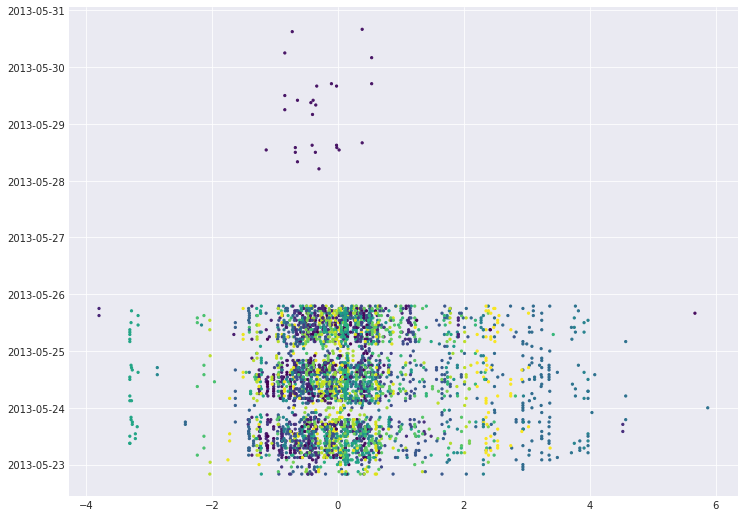

In [57]:
plt.scatter(X_pca, X_train.index.get_level_values('tstamp'), c=df.cluister, s=5, cmap='viridis')
plt.savefig('1.png')

После 2013.05.26 для большинства номеров отсутствуют данные

In [43]:
X_train

long       lat  max_dist  start_angle  \
msisdn       tstamp                                                           
158500002513 2013-05-23 02:00:00  1.231314  2.925624  1.480926     0.413377   
             2013-05-23 07:00:00  1.231314  2.925624  1.480926     0.413377   
             2013-05-24 00:00:00  1.231314  2.925624  1.480926     0.413377   
             2013-05-24 14:00:00  1.231314  2.925624  1.480926     0.413377   
             2013-05-24 16:00:00  1.231314  2.925624  1.480926     0.413377   
...                                    ...       ...       ...          ...   
158599999863 2013-05-25 15:00:00  0.119178 -0.007499  0.002089     0.320623   
             2013-05-25 16:00:00  0.265939 -0.370334 -1.301353    -1.441709   
             2013-05-25 17:00:00  0.265939 -0.370334 -1.301353    -1.441709   
             2013-05-25 18:00:00  0.297897 -0.350526 -0.504872     0.784395   
             2013-05-25 19:00:00  0.297897 -0.350526 -0.504872     0.784395   

                                  end_angle  cell_type  
msisdn       tstamp                                     
158500002513 2013-05-23 02:00:00   0.975180          2  
             2013-05-23 07:00:00   0.975180          2  
             2013-05-24 00:00:00   0.975180          2  
             2013-05-24 14:00:00   0.975180          2  
             2013-05-24 16:00:00   0.975180          2  
...                                     ...        ...  
158599999863 2013-05-25 15:00:00   0.882216          2  
             2013-05-25 16:00:00  -0.884091          2  
             2013-05-25 17:00:00  -0.884091          2  
             2013-05-25 18:00:00   1.347034          2  
             2013-05-25 19:00:00   1.347034          2  

[54656 rows x 6 columns]

In [44]:
X_pivot = X_train[X_train.index.get_level_values('tstamp') < '2013-05-26 00:00:00'].reset_index().pivot(index='msisdn', columns='tstamp', values=['long', 'lat'])

Одна персона с большой долей вероятности носит с собой устройства с разными номерами (msisdn), поэтому данные о перемещениях этих устройств будут коррелировать между собой. Оценить взаимосвязь можно через коэффициент корреляции

In [45]:
X_pivot = X_pivot.fillna(method='ffill').fillna(method='bfill')

In [46]:
corr_matrix = X_pivot.T.corr()

In [47]:
y_pred = corr_matrix.unstack().sort_values()

In [48]:
y_pred = y_pred.reset_index(level=1) \
                .rename(columns={'msisdn': 'msisdn_pair', 0: 'corr'}) \
                .reset_index(level=0).dropna()

In [49]:
y_pred = y_pred[~(y_pred.msisdn == y_pred.msisdn_pair)]

In [50]:
fact_pred = y_pred.merge(df_cluister, how='left', left_on='msisdn', right_on='msisdn', suffixes=['_pred', '_test'])

In [51]:
fact_pred[(fact_pred.msisdn_pair_pred == fact_pred.msisdn_pair_test) & (fact_pred['corr'] > 0.8)]

,msisdn,msisdn_pair_pred,corr,cluister,msisdn_pair_test
5562152,158535971159,158535970759,0.802946,103.0,158535970759
5562153,158535970759,158535971159,0.802946,103.0,158535971159
5562448,158528861475,158528852153,0.817884,4.0,158528852153
5562449,158528852153,158528861475,0.817884,4.0,158528861475
5562580,158522134783,158522134689,0.824527,72.0,158522134689
5562581,158522134689,158522134783,0.824527,72.0,158522134783
5562592,158525436943,158525436983,0.824857,62.0,158525436983
5562593,158525436983,158525436943,0.824857,62.0,158525436943
5562640,158505653139,158505653213,0.827320,102.0,158505653213
5562641,158505653213,158505653139,0.827320,102.0,158505653139


In [52]:
y_pred = y_pred.groupby('msisdn').last()

In [53]:
y_pred = y_pred[y_pred['corr'] > 0.8]

In [54]:
y_pred

,msisdn_pair,corr
msisdn,,
158500002513,158500006927,0.865128
158500006927,158500002513,0.865128
158500010757,158500006927,0.854471
158500019021,158500020139,0.990722
158500020139,158500019021,0.990722
...,...,...
158599893059,158599877651,0.860593
158599919033,158599940677,0.811583
158599940677,158599919033,0.811583


In [55]:
y_pred[['msisdn_pair']].reset_index().to_csv('facts_pred.txt', header=False)

[Go to the top of the page](#top)